In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import math

In [2]:
df = pd.read_csv("1976-2020-senate.csv")

In [3]:
selected_states = ['NEW HAMPSHIRE', 'NORTH CAROLINA', 'OKLAHOMA', 'OREGON', 'SOUTH CAROLINA', 'SOUTH DAKOTA']
filtered_df = df[df['state'].isin(selected_states)]

In [4]:
states = filtered_df['state'].unique()
party_order = ['REPUBLICAN', 'DEMOCRAT']
colors = {'REPUBLICAN': 'red', 'DEMOCRAT': 'blue'} # BONUS 
df_dict = {}

plot_index = 0
for state in states:
    for party in party_order:
        state_party_data = df[(df['state'] == state) & (df['party_simplified'] == party)  & (df['special'] == False)]
        state_party_data = state_party_data[state_party_data['writein'] == False]
        df_dict[(state, party)] = state_party_data

In [5]:
cols = ['year', 'candidatevotes', 'totalvotes']
df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')][cols]

,year,candidatevotes,totalvotes
221,1978,133745,263760
346,1980,195559,375060
607,1984,225828,384369
719,1986,154090,244735
956,1990,189792,291393
1100,1992,249591,518170
1415,1996,242257,491873
1568,1998,213477,314696
1905,2002,227229,447135
2059,2004,434847,657086


In [6]:
def sir_model(t, y, beta, gamma):
    '''' y is tuple with 
    (S, I, R) - > (Voters (infuencible), Opioniated voters (voter percentage for chosen candidate), Recovered (Voters who change sides) 
    
    '''
    S, I, R = y
    dSdt = -beta * S * I # It can go both ways ? 
    dIdt = beta * S * I - gamma * I # what is the mechanism for this. What is gamma a function of ? 
    dRdt = gamma * I # potenitally, beta and gamma are funcitons of time ? 
    return [dSdt, dIdt, dRdt]

In [7]:
def fit_sir_model(t, beta, gamma, S0, I0, R0):
    '''What is the return value?'''
    sol = solve_ivp(sir_model, [t[0], t[-1]], [S0, I0, R0], t_eval=t, args=(beta, gamma))
    return sol.y[1] # returns S, I, R as they change wrt time. y[1] gives I 

In [8]:
year = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['year'].values
votes = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes
I0 = vote_percentage[0]
S0 = 1 - I0
R0 = 0

# fit the curve provided initial guess. 0.1 each | Gives local optimum
params, covariance = curve_fit(fit_sir_model, year, vote_percentage, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
print(f"Fitted parameters: beta={beta}, gamma={gamma}")

Fitted parameters: beta=0.05437961974024848, gamma=0.03446399288914471


In [9]:
fitted_voter_percentage = fit_sir_model(year, *params)

In [10]:
split_index = int(0.8 * len(year))

X_train, X_test = year[:split_index], year[split_index:]
y_train, y_test = vote_percentage[:split_index], vote_percentage[split_index:]
params, covariance = curve_fit(fit_sir_model, X_train, y_train, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
print(f"Fitted parameters: beta={beta}, gamma={gamma}")
test_fit = (fit_sir_model(year, *params))


Fitted parameters: beta=0.5671977313548615, gamma=0.003656337852165502


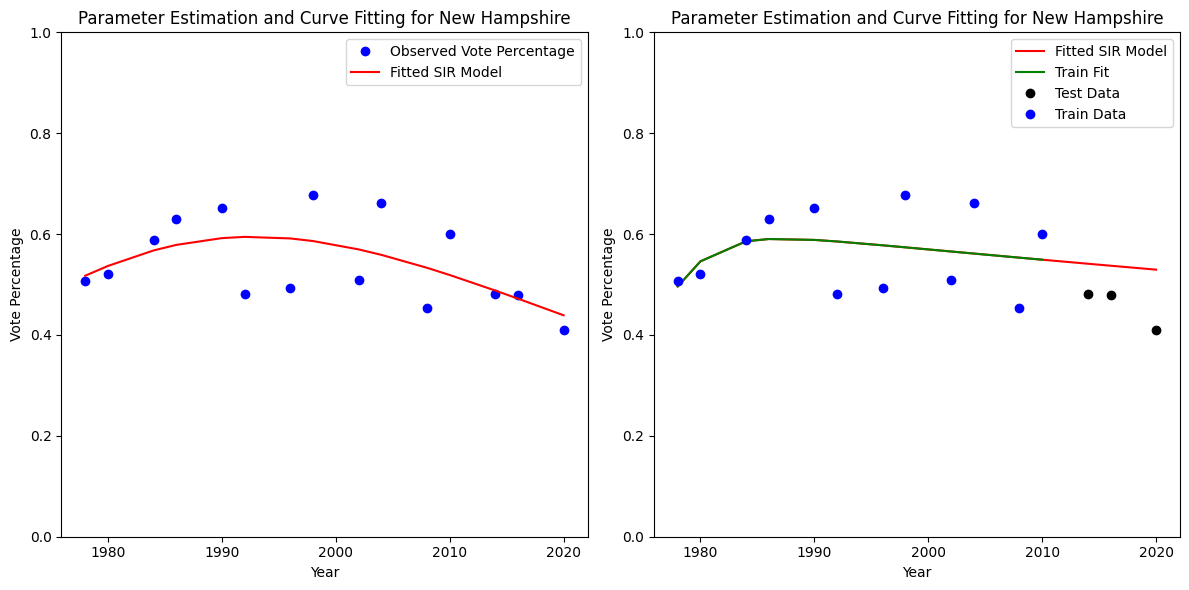

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First plot
axes[0].plot(year, vote_percentage, 'bo', label='Observed Vote Percentage')
axes[0].plot(year, fitted_voter_percentage, 'r-', label='Fitted SIR Model')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Vote Percentage')
axes[0].set_ylim(0, 1)
axes[0].legend()
axes[0].set_title('Parameter Estimation and Curve Fitting for New Hampshire')

# Second plot
axes[1].plot(year, test_fit, 'r-', label='Fitted SIR Model')
axes[1].plot(X_train, fit_sir_model(X_train, *params), 'g-', label='Train Fit')
axes[1].plot(X_test, y_test, 'ko', label='Test Data')
axes[1].plot(X_train, y_train, 'bo', label='Train Data')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Vote Percentage')
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].set_title('Parameter Estimation and Curve Fitting for New Hampshire')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [12]:
year = df_dict[('OREGON', 'REPUBLICAN')]['year'].values
votes = df_dict[('OREGON', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('OREGON', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes
split_index = int(0.8 * len(year))

X_train, X_test = year[:split_index], year[split_index:]
y_train, y_test = vote_percentage[:split_index], vote_percentage[split_index:]
I0 = vote_percentage[0]
S0 = 1 - I0
R0 = 0

# fit the curve provided initial guess. 0.1 each | Gives local optimum
params, covariance = curve_fit(fit_sir_model, X_train, y_train, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
test_fit = (fit_sir_model(year, *params))
print(f"Fitted parameters: beta={beta}, gamma={gamma}")

Fitted parameters: beta=0.46666726194970787, gamma=0.019099405182226872


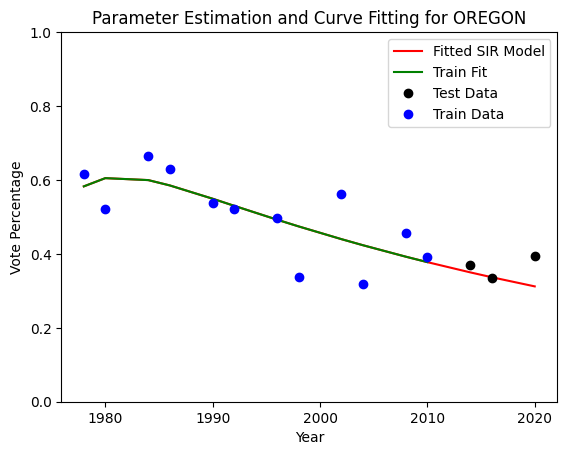

In [13]:
plt.plot(year, test_fit, 'r-', label='Fitted SIR Model')
plt.plot(X_train, fit_sir_model(X_train, *params), 'g-', label='Train Fit')
plt.plot(X_test, y_test, 'ko', label='Test Data')
plt.plot(X_train, y_train, 'bo', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation and Curve Fitting for OREGON')
plt.show()

# Other states

In [14]:
selected_states = ['NEW HAMPSHIRE', 'NORTH CAROLINA', 'OKLAHOMA', 'OREGON', 'SOUTH CAROLINA', 'SOUTH DAKOTA']
filtered_df = df[df['state'].isin(selected_states)]

Fitted parameters: beta=0.05437961974024848, gamma=0.03446399288914471 for the state NEW HAMPSHIRE and party REPUBLICAN
Fitted parameters: beta=0.0053553881712839575, gamma=8.839005612503529e-13 for the state NEW HAMPSHIRE and party DEMOCRAT
Fitted parameters: beta=5.720970803236229e-08, gamma=0.0013536798766012772 for the state NORTH CAROLINA and party REPUBLICAN
Fitted parameters: beta=0.9999999282134492, gamma=0.0010866281642767847 for the state NORTH CAROLINA and party DEMOCRAT
Fitted parameters: beta=0.039956134955140894, gamma=0.01184614836606754 for the state OKLAHOMA and party REPUBLICAN
Fitted parameters: beta=0.35241201685102, gamma=0.027369844572261354 for the state OKLAHOMA and party DEMOCRAT
Fitted parameters: beta=0.5512248063682575, gamma=0.016392410430557572 for the state OREGON and party REPUBLICAN
Fitted parameters: beta=0.03470691357511617, gamma=0.014649297267868221 for the state OREGON and party DEMOCRAT
Fitted parameters: beta=0.02008902053300457, gamma=0.01124924

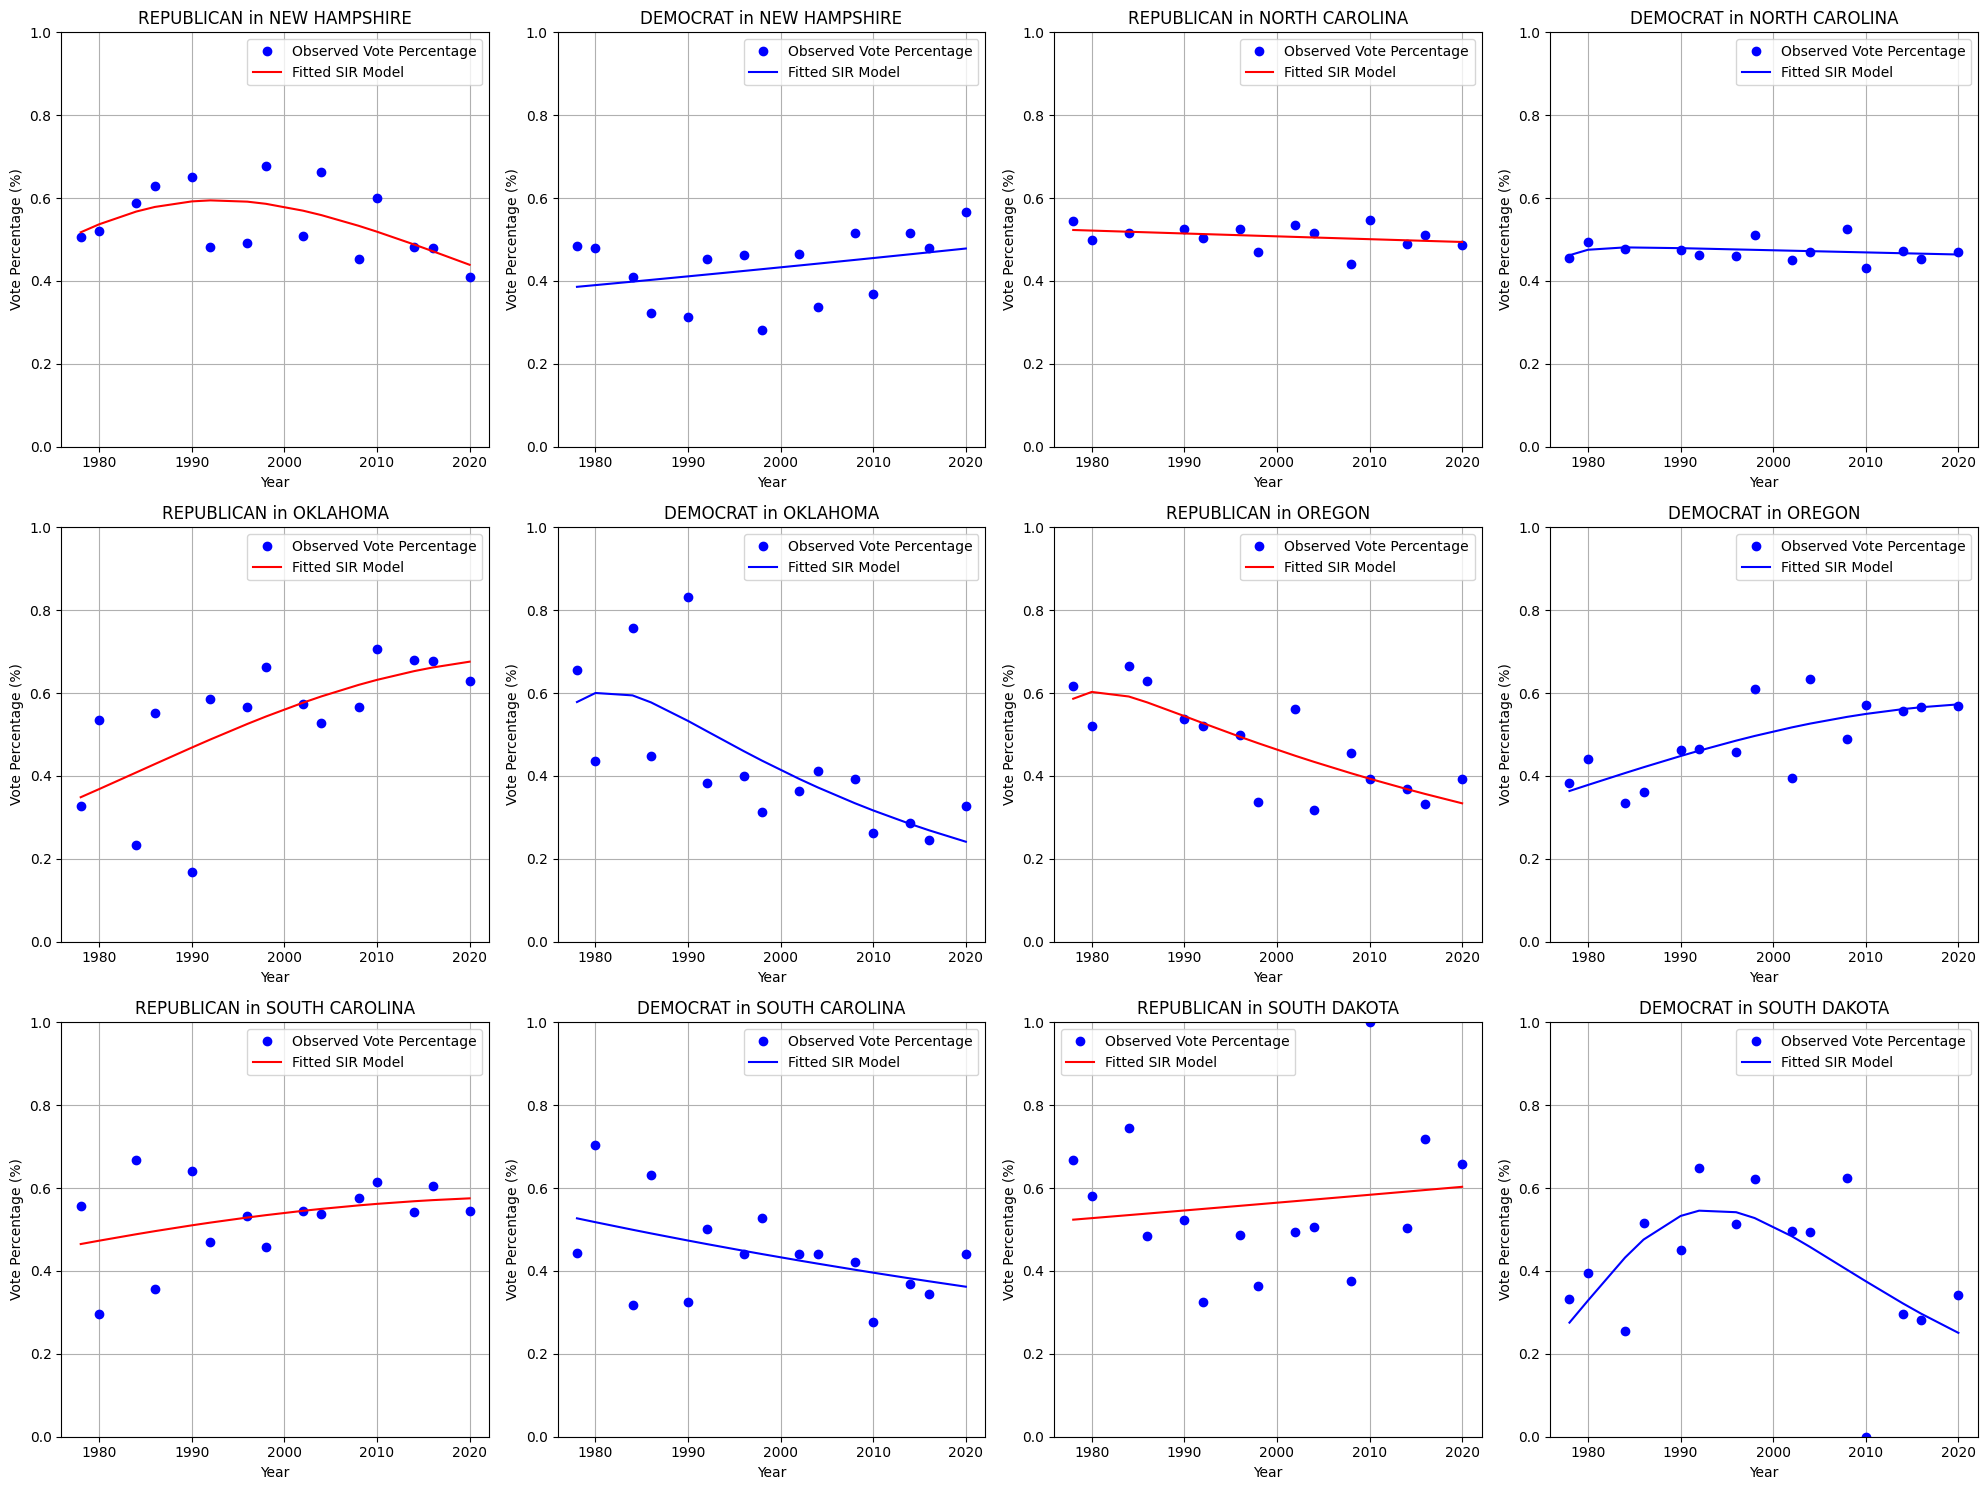

In [15]:
num_plots = len(states) * len(party_order)
cols = 4  # Number of columns in the grid
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()
ssr = {}
plot_index = 0
for state in states:
    for party in party_order:
        index = (state, party)
        year = df_dict[index]['year'].values
        votes = df_dict[index]['candidatevotes'].values
        total_votes = df_dict[index]['totalvotes'].values
        vote_percentage = votes / total_votes
        I0 = vote_percentage[0]
        S0 = 1 - I0
        R0 = 0

        # fit the curve provided initial guess. 0.1 each | Gives local optimum
        params, covariance = curve_fit(fit_sir_model, year, vote_percentage, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
        beta, gamma = params[:2]
        print(f"Fitted parameters: beta={beta}, gamma={gamma} for the state {state} and party {party}")
        fitted_voter_percentage = fit_sir_model(year, *params)
        ssr[index] = np.sqrt(np.mean(np.dot((fitted_voter_percentage - vote_percentage).T, (fitted_voter_percentage - vote_percentage)))) * 100
        ax = axes[plot_index]
        ax.plot(year, vote_percentage, 'bo', label='Observed Vote Percentage')
        ax.plot(year, fitted_voter_percentage, label='Fitted SIR Model', color=colors[party])
        ax.set_title(f'{party} in {state}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Vote Percentage (%)')
        ax.set_ylim(0, 1)
        ax.legend()
        ax.grid(True)
        plot_index += 1
        
for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [16]:
ssr

{('NEW HAMPSHIRE', 'REPUBLICAN'): 25.76717620921522,
 ('NEW HAMPSHIRE', 'DEMOCRAT'): 30.27441400683261,
 ('NORTH CAROLINA', 'REPUBLICAN'): 10.082360385700689,
 ('NORTH CAROLINA', 'DEMOCRAT'): 8.781055585871446,
 ('OKLAHOMA', 'REPUBLICAN'): 45.29631304834167,
 ('OKLAHOMA', 'DEMOCRAT'): 46.603480258506785,
 ('OREGON', 'REPUBLICAN'): 26.19044656125085,
 ('OREGON', 'DEMOCRAT'): 23.805486528380722,
 ('SOUTH CAROLINA', 'REPUBLICAN'): 35.110012066064996,
 ('SOUTH CAROLINA', 'DEMOCRAT'): 38.4597955395549,
 ('SOUTH DAKOTA', 'REPUBLICAN'): 64.53763237629168,
 ('SOUTH DAKOTA', 'DEMOCRAT'): 51.82284450371474}

# Grid Search

In [17]:
def sir_model2(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I  - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

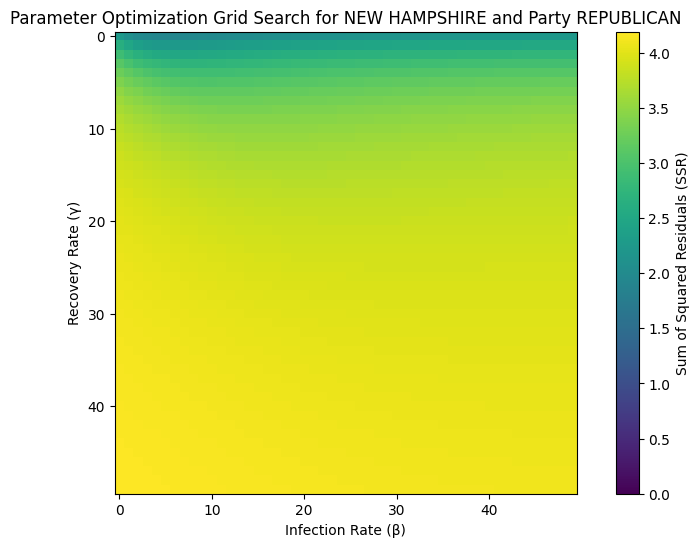

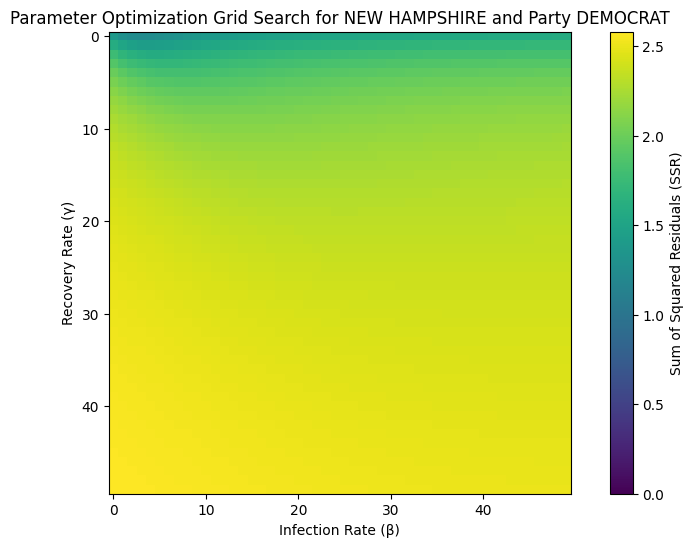

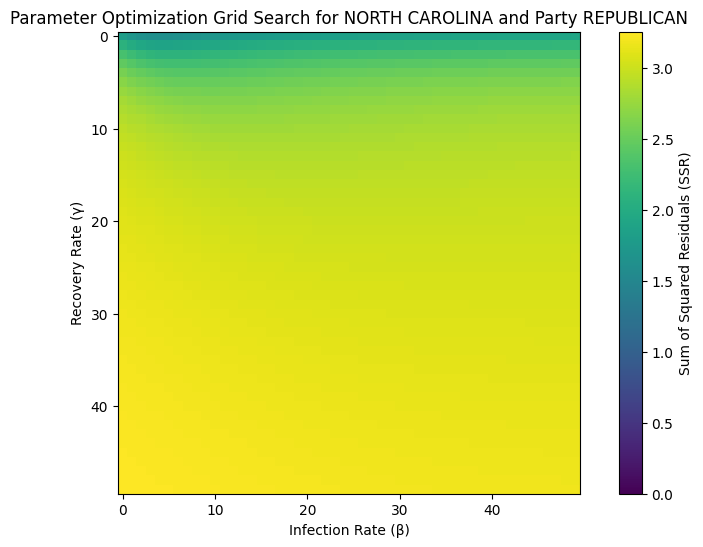

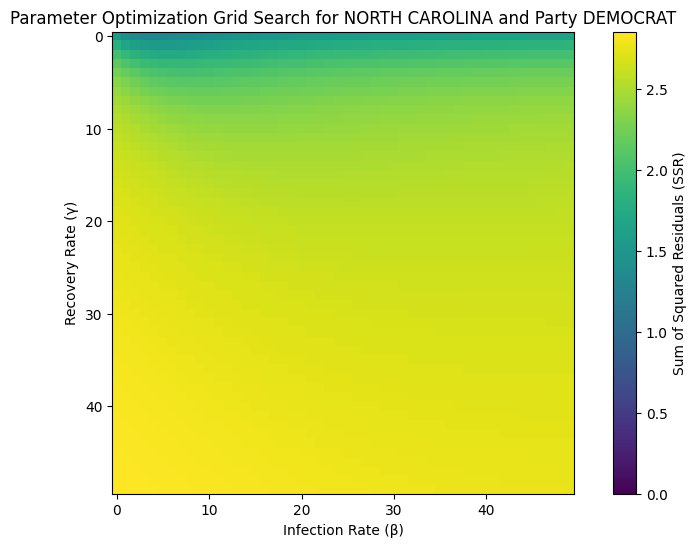

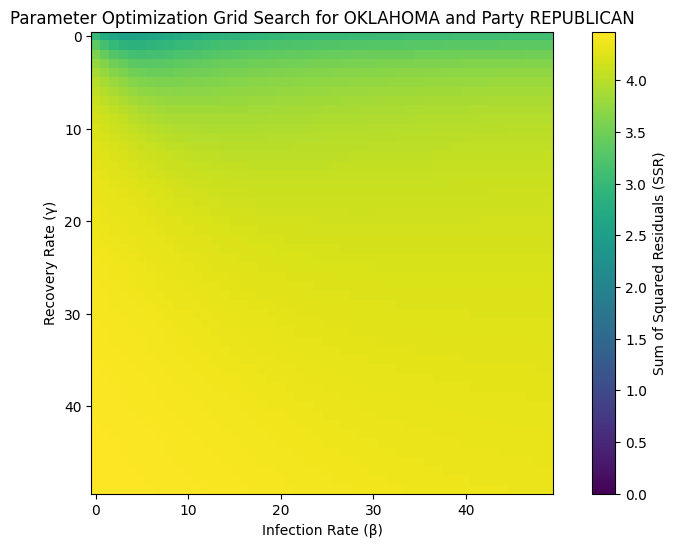

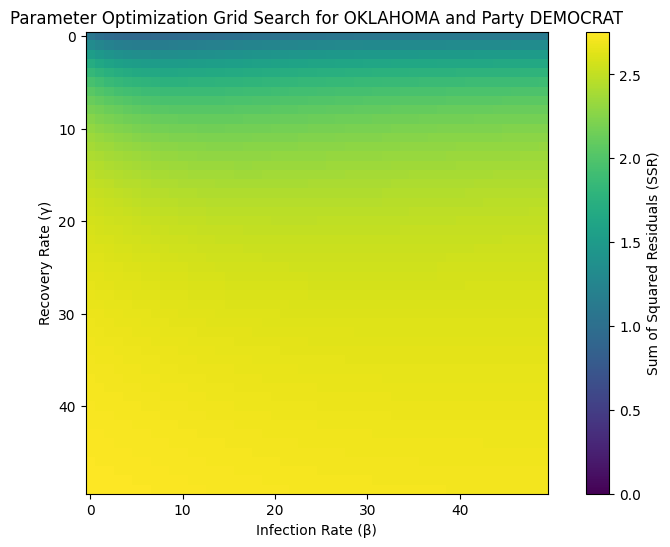

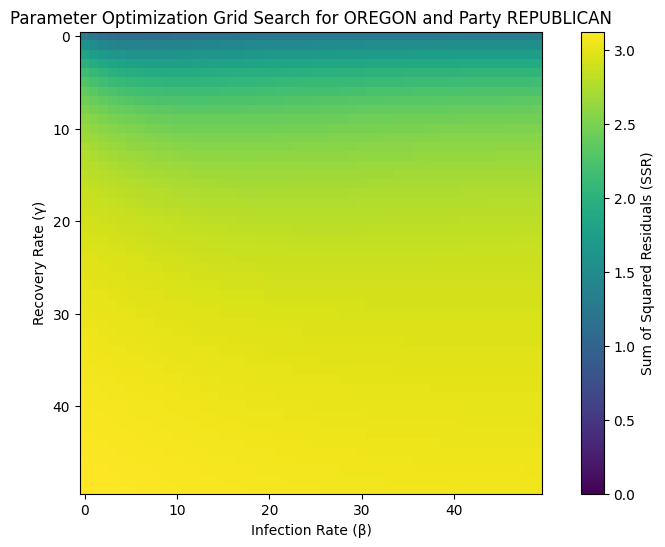

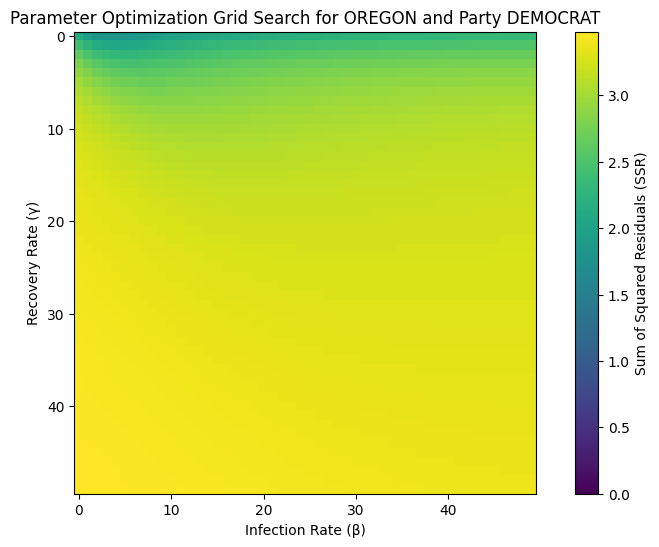

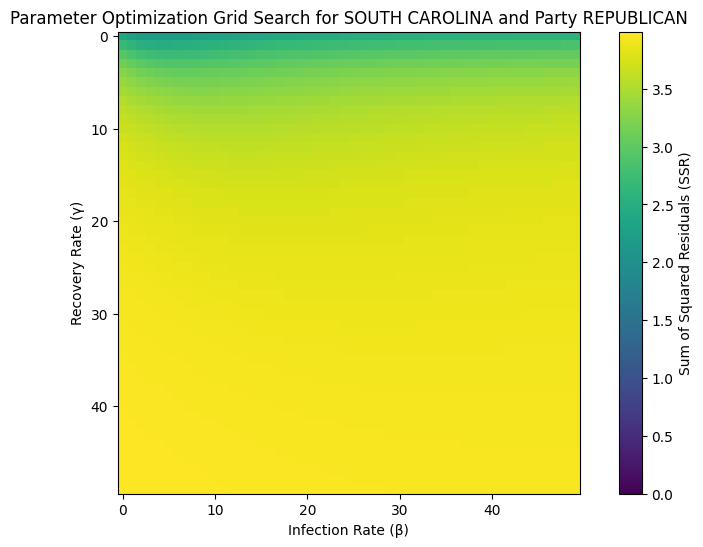

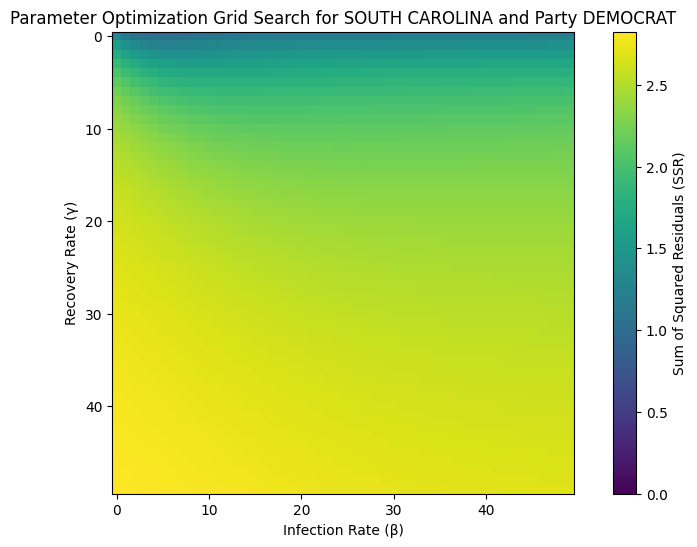

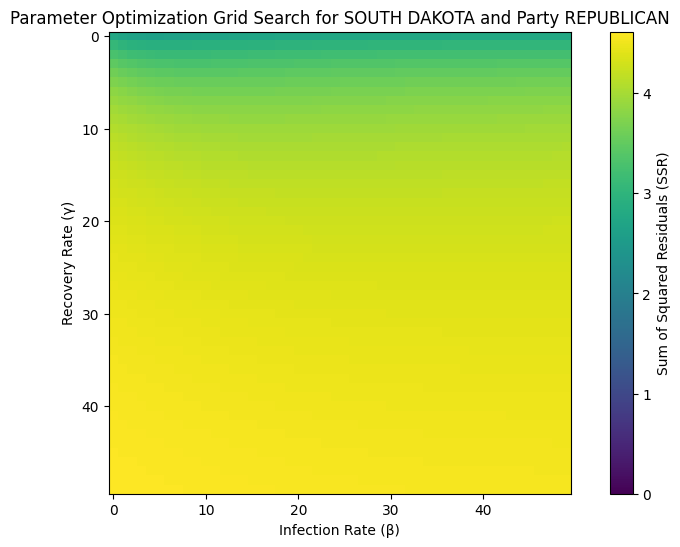

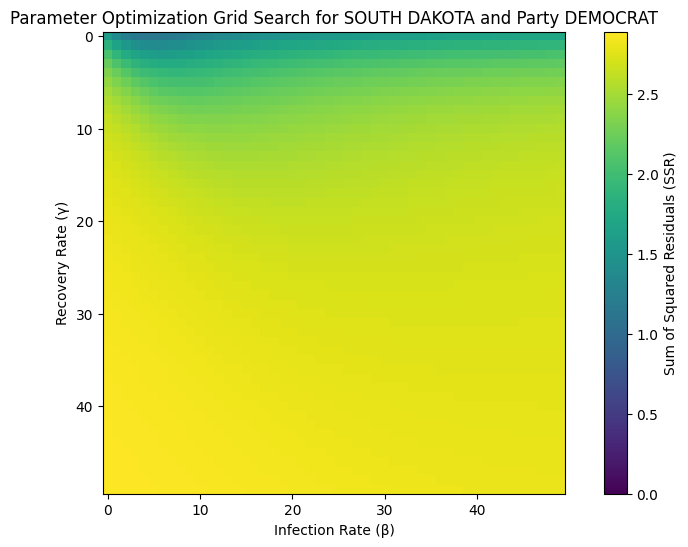

In [26]:
num_plots = len(states) * len(party_order)
cols = 4  # Number of columns in the grid
rows = math.ceil(num_plots / cols)

ssr = {}
beta_vals = np.linspace(0.1, 2.0, 50)
gamma_vals = np.linspace(0.1, 1.0, 50)
B, G = np.meshgrid(beta_vals, gamma_vals)
ssr_grid = np.zeros_like(B)

for state in states:
    for party in party_order:
        index = (state, party)
        year = df_dict[index]['year'].values
        votes = df_dict[index]['candidatevotes'].values
        total_votes = df_dict[index]['totalvotes'].values
        vote_percentage = votes / total_votes
        I0 = vote_percentage[0]
        S0 = 1 - I0
        R0 = 0

        for i in range(len(beta_vals)):
            for j in range(len(gamma_vals)):
                sol = odeint(sir_model2, [S0, I0, R0], year, args=(B[i,j], G[i,j]))
                I_pred = sol[:, 1]
                ssr_grid[i,j] = np.sum((I_pred - vote_percentage)**2)

        # Create heatmap plot
        plt.figure(figsize=(10, 6))
        contour = plt.imshow(ssr_grid, cmap='viridis', vmin=0, vmax= np.max(ssr_grid))
        plt.colorbar(contour, label='Sum of Squared Residuals (SSR)')
        plt.xlabel('Infection Rate (β)')
        plt.ylabel('Recovery Rate (γ)')
        plt.title(f'Parameter Optimization Grid Search for {state} and Party {party}')
        plt.show()
                
        